<a href="https://colab.research.google.com/github/TonyLiu836/Road-Network-Extraction-And-Route-Travel-Time-Estimation/blob/main/Spacenet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/CSCI5525Project"
%pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CSCI5525Project


'/content/drive/MyDrive/CSCI5525Project'

In [3]:
!pip install geopandas    #==0.6.3   #latest version of geopandas changes CRS objects, 0.6.3 works when generating training masks - otherwise shouldnt matter
!pip install imagecodecs    
!pip install osmnx
!pip install scikit-image

     |████████████████████████████████| 1.0 MB 9.5 MB/s 
     |████████████████████████████████| 16.7 MB 19.6 MB/s 
     |████████████████████████████████| 6.3 MB 2.7 MB/s 
     |████████████████████████████████| 31.0 MB 121 kB/s 
     |████████████████████████████████| 95 kB 4.1 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 11.2 MB 143 kB/s 
     |████████████████████████████████| 1.0 MB 48.0 MB/s 
     |████████████████████████████████| 900 kB 58.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following

# Data Prep & Training Mask Generation (No Need to Run)

In [ ]:
from PIL import Image   #PIL can't open 16bit images, only 8bit

im = Image.open('/content/drive/MyDrive/CSCI5525Project/SN3_roads_train_AOI_3_Paris_PS-RGB_img10.tif')
im.show()

FileNotFoundError: ignored

In [ ]:
#!unzip /content/drive/MyDrive/CSCI5525Project/paris.zip -d /home

!cp -r paris_PSMS_8bit /home
!cp -r paris_geojson_roads_speed/ /home

cp: cannot stat 'paris_PSMS_8bit': No such file or directory
cp: cannot stat 'paris_geojson_roads_speed/': No such file or directory


In [ ]:
#DONT NEED TO RUN THIS 

#convert 16-bit satellite images into 8-bit for Paris Dataset
!python create_8bit_images.py \
    --indir="/home/paris/AOI_3_Paris/PS-MS" \
    --outdir="/content/drive/MyDrive/CSCI5525Project/paris_PSMS_8bit" \
    --rescale_type=perc \
    --percentile=2,98 \
    --band_order=5,3,2

#create road speed mask for Paris Dataset 
!python speed_masks.py \
    --geojson_dir="/home/paris_geojson_roads_speed" \
    --image_dir="/home/paris_PSMS_8bit" \
    --output_conversion_csv_binned="/content/drive/MyDrive/CSCI5525Project/paris_roads_train_speed_conversion_binned.csv" \
    --output_mask_dir_contin="/content/drive/MyDrive/CSCI5525Project/paris_training_masks_contin" \
    --output_mask_multidim_dir="/content/drive/MyDrive/CSCI5525Project/paris_train_mask_binned_mc" \
    --buffer_distance_meters=2

python3: can't open file 'create_8bit_images.py': [Errno 2] No such file or directory
python3: can't open file 'speed_masks.py': [Errno 2] No such file or directory


# Visualize Sample and training mask





im shape (1300, 1300, 3)
multi-channel mask shape: (1300, 1300, 8)
1690000


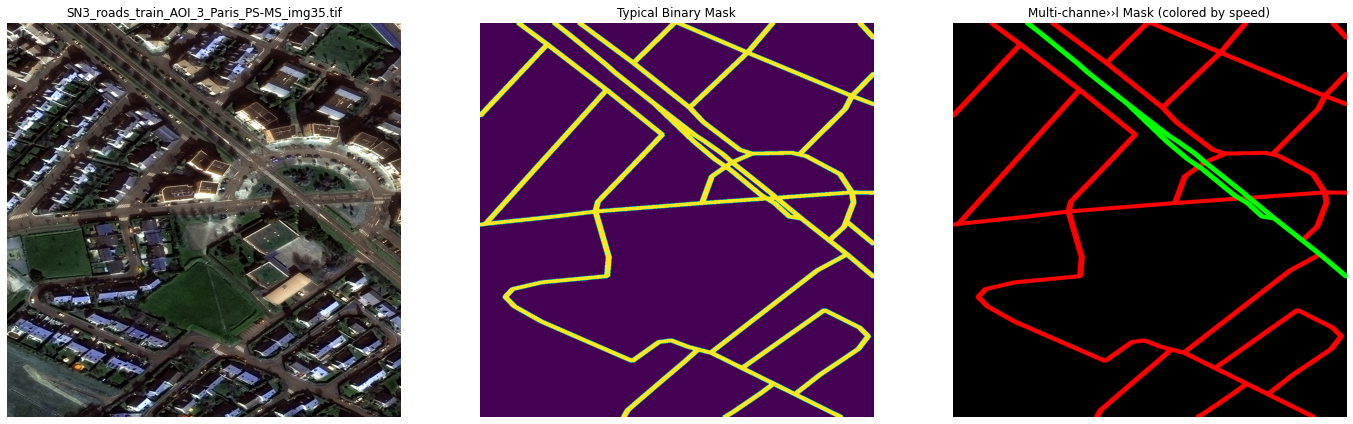

In [2]:
#visualize multi-channel mask 
import os
import cv2
import skimage.io
import numpy as np
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt

im_dir = '/content/drive/MyDrive/CSCI5525Project/paris/paris_PSMS_8bit'
mask_dir = '/content/drive/MyDrive/CSCI5525Project/paris/paris_train_mask_binned_mc'
im_name = 'SN3_roads_train_AOI_3_Paris_PS-MS_img35.tif'
im_path = os.path.join(im_dir, im_name)
mask_mc_path = os.path.join(mask_dir, im_name)

# plot
fig, ((ax0, ax1, ax2)) = plt.subplots(1,3, figsize=(24,9))

# image
im = cv2.imread(im_path, 1)
ax0.imshow(cv2.imread(im_path, 1))
print("im shape",np.shape(im))        #1300x1300x3
ax0.axis('off')
ax0.set_title(im_name)

mask_mc = skimage.io.imread(mask_mc_path)
print("multi-channel mask shape:", mask_mc.shape)

# binary mask
ax1.imshow(mask_mc[:,:,-1])
ax1.axis('off')
ax1.set_title('Typical Binary Mask')

# 8 channel mask
z = ax2.imshow(mask_mc[:,:,2:5])
ax2.axis('off')
ax2.set_title('Multi-channe››l Mask (colored by speed)')    


from PIL import Image

def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width*height

print(get_num_pixels("/content/drive/MyDrive/CSCI5525Project/paris/paris_PSMS_8bit/SN3_roads_train_AOI_3_Paris_PS-MS_img35.tif"))

# Slice Images (1300x1300 -> ~200x200)

In [ ]:
import pandas as pd
#code from 
def slice_imgs(img_arr, mask_arr, names_arr, slice_x, slice_y, stride_x, stride_y, pos_columns = ['idx', 'name', 'xmin', 'ymin', 'slice_x', 'slice_y', 'im_x','im_y'], verbose=True):
 
    if verbose:
        print("slicing imgs and masks...")
    t0 = time.time()
    mask_buffer = 0
    count = 0
    im_list, mask_list, name_list, pos_list = [],[],[],[]
    num_imgs, h,w,num_bands = img_arr.shape
    
    for i, (img,mask, name) in enumerate(zip(img_arr, mask_arr, names_arr)):
          seen_coords = set()
          if verbose and (i%100) == 0:
              print(i,"img shape=",im.shape, "  mask shape=", mask.shape)
          
          #slice imgs

          for x in range(0, w-1, stride_x):
              for y in range(0, h-1, stride_y):

                  xmin = min(x, w-slice_x)
                  ymin = min(y, h-slice_y)
                  coords = (xmin, ymin)

                  #check if coords have been seen 
                  if coords in seen_coords:
                      continue
                  else:
                      seen_coords.add(coords)

                  #check if binning correctly
                  if (xmin + slice_x > w) or (ymin + slice_y > h):
                      print("improperly binned img")
                      return 

                  img_cutout = im[ymin:ymin + slice_y, xmin:xmin+slice_x]


                  #check if slice is complete black, if so then skip 
                  if np.max(img_cutout) < 1:
                      continue
                  else:
                      count += 1
                  

                  #get mask cutout
                  x1, y1 = xmin + mask_buffer, ymin+mask_buffer
                  mask_cutout = mask[y1:y1+slice_y, x1:x1+slice_x]

                  #give slice a name
                  name_full = str(i) + "_" + name + "_" + str(xmin)+'_'+str(ymin)+'_'+str(slice_x)+'_'+str(slice_y)+'_'+str(w)+'_'+str(h)
                  pos = [i, name, xmin, ymin, slice_x, slice_y, w, h]

                  #add to arrays
                  name_list.append(name_full)
                  im_list.append(img_cutout)
                  mask_list.append(mask_cutout)
                  pos_list.append(pos)

    # convert to np arrays
    del img_arr
    del mask_arr
    name_out_arr = np.array(name_list)
    im_out_arr = np.array(im_list)
    mask_out_arr = np.array(mask_list)
    
    # create position datataframe
    df_pos = pd.DataFrame(pos_list, columns=pos_columns)
    df_pos.index = np.arange(len(df_pos))
    
    if verbose:
        print ("  im_out_arr.shape;", im_out_arr.shape)
        print ("  mask_out_arr.shape:", mask_out_arr.shape)
        print ("  mask_out_arr[0] == mask_out_arr[1]?:", 
                   np.array_equal(mask_out_arr[0], mask_out_arr[1]))
        print ("  Time to slice arrays:", time.time() - t0, 
               "seconds")
        
    return df_pos, name_out_arr, im_out_arr, mask_out_arr              


# Split Data (Don't need to run again)

In [3]:
#works but isnt exactl what we want (cant split imgs along with masks and geojsons )
!pip install split-folders  #lets you split data in folders directly into train/test splits
import splitfolders 

#splitfolders.ratio("/content/drive/MyDrive/CSCI5525Project/experimentsplitdata", output="/content/drive/MyDrive/CSCI5525Project/outputsplitdata", seed = 1337, ratio=(0.8,0.2), group_prefix=2)

splitfolders.ratio("/content/drive/MyDrive/CSCI5525Project/experimentsplitdata", output="/content/drive/MyDrive/CSCI5525Project/outputsplitdata", seed = 1337, ratio=(0.8,0.2))


In [25]:
#*************DO NOT RUN THIS*****************************
#**********TEST VERSION********************
import os
from glob import glob
import shutil
from sklearn.model_selection import train_test_split
import re 

#splits files into train and test (70/30)

def batch_move_files(file_list, AOI, img_path, gjson_path, mask_path, destination_path):
    for file in file_list:
        #extracting only the name of the file and concatenating with extenions
        city =  AOI.split('_')[-1].lower()
        if not os.path.isdir(destination_path +"/"+ city + "_PSMS_8bit"):
            os.mkdir(destination_path +"/"+ city + "_PSMS_8bit")
        if not os.path.isdir(destination_path +"/"+ city + "_geojson"):
            os.mkdir(destination_path +"/"+ city + "_geojson")
        if not os.path.isdir(destination_path +"/"+ city + "_masks"):
            os.mkdir(destination_path +"/"+ city + "_masks")
        
        
        imgNum = re.findall("\d+", file)[-1]
        #print("file", file)
        #image = file.split('\\')[1] + '.tif'
        image = file + '.tif'
        if AOI == "SN5_roads_train_AOI_8_Mumbai":
            gjson = AOI + "_geojson_roads_speed_chip" + str(imgNum)+ ".geojson"
            mask = AOI+"_PS-MS_chip"+str(imgNum)+".tif"
        else:
            gjson = AOI+"_geojson_roads_speed_img" + str(imgNum) + ".geojson"
            #print("gjson", gjson)
            mask = AOI+"_PS-MS_img"+str(imgNum)+".tif"
            #print("mask", mask)
        #xml = file.split('\\')[1] + '.xml'
        #gjson = file.split('\\')[1]+'.geojson'
        #print("image", image)
        #print("os join", os.path.join(img_path, image))
        #print("gjson", gjson)
        shutil.copy(os.path.join(img_path, image), destination_path +"/"+ city + "_PSMS_8bit")
        shutil.copy(os.path.join(gjson_path, gjson), destination_path +"/"+ city + "_geojson")
        shutil.copy(os.path.join(mask_path, mask), destination_path + "/"+ city + "_masks")
    return

#source_dir = "E:/ML/DataSet/"
#test_dir = "E:/ML/test/"
#train_dir = "E:/ML/train/"
#batch_move_files(train_names, source_dir, train_dir)
#batch_move_files(test_names, source_dir, test_dir)
#city = "paris"
#AOI = "SN3_roads_train_AOI_3_Paris"

#getting list of images
#image_files = glob("E:/ML/DataSet/*.jpg")
img_dirs = [ "/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/mumbai/*.tif", "/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/paris/*.tif","/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/shanghai/*.tif"]

#image_files = glob("/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/paris/*.tif")
#print(image_files)
#replacing the extension
#images = [name.replace(".tif","") for name in image_files]

#splitting the dataset
#train_names, test_names = train_test_split(images, test_size=0.2)

AOI = ["SN5_roads_train_AOI_8_Mumbai", "SN3_roads_train_AOI_3_Paris", "SN3_roads_train_AOI_4_Shanghai"]
train_parent_dir = "/content/drive/MyDrive/CSCI5525Project/outputsplitdata/train"
test_parent_dir = "/content/drive/MyDrive/CSCI5525Project/outputsplitdata/test"

for dir in range(len(img_dirs)):
    image_files = glob(img_dirs[dir])
    images = [name.replace(".tif","") for name in image_files]
    #print("imgaes=", images)
    #for region in AOI:
    region = AOI[dir]
    train_names, test_names = train_test_split(images, test_size=0.3)
    print(train_names)
    print(test_names)
    city =  region.split('_')[-1].lower()
    #print("city=", city)
    img_dir = "/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/" + city
    gjson_dir = "/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/" + city + "_geojson"
    mask_dir = "/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/" + city + "_masks"
    #img_destination = ""  
    batch_move_files(train_names, region, img_dir, gjson_dir, mask_dir, train_parent_dir)
    batch_move_files(test_names, region, img_dir,gjson_dir,mask_dir, test_parent_dir)
    #print("reaches here")


['/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/mumbai/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip1', '/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/mumbai/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip3', '/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/mumbai/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip4']
['/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/mumbai/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip0', '/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/mumbai/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip2']
['/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/paris/SN3_roads_train_AOI_3_Paris_PS-MS_img10', '/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/paris/SN3_roads_train_AOI_3_Paris_PS-MS_img30', '/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/paris/SN3_roads_train_AOI_3_Paris_PS-MS_img20', '/content/drive/MyDrive/CSCI5525Project/experimentsplitdata/paris/SN3_roads_train_AOI_3_Paris_PS-MS_img19', '/content/drive

In [31]:

#!mkdir /home/completedata/
#!cp -r /content/drive/MyDrive/CSCI5525Project/paris/paris_PSMS_8bit /home/completedata
#!cp -r /content/drive/MyDrive/CSCI5525Project/paris/paris_geojson_roads_speed /home/completedata
#!cp -r /content/drive/MyDrive/CSCI5525Project/paris/paris_train_mask_binned_mc /home/completedata

#!unzip /content/drive/MyDrive/CSCI5525Project/shanghai/shanghai_PS-RGB_8bit.zip -d /home/completedata

#!unzip /content/drive/MyDrive/CSCI5525Project/mumbai/mumbai_PS-RGB_8bit.zip -d /home/completedata

#!!cp -r /content/drive/MyDrive/CSCI5525Project/mumbai/mumbai_geojson_roads_speed /home/completedata
#!cp -r /content/drive/MyDrive/CSCI5525Project/mumbai/mumbai_train_mask_binned_mc /home/completedata

#!cp -r /content/drive/MyDrive/CSCI5525Project/shanghai/shanghai_geojson_roads_speed /home/completedata
#!cp -r /content/drive/MyDrive/CSCI5525Project/shanghai/shanghai_train_mask_binned_mc /home/completedata



In [34]:
import os
from glob import glob
import shutil
from sklearn.model_selection import train_test_split
import re 

#splits imgs and corresponding masks/geojson files into train and test (70/30)

def batch_move_files(file_list, AOI, img_path, gjson_path, mask_path, destination_path):
    for file in file_list:
        #extracting only the name of the file and concatenating with extenions
        city =  AOI.split('_')[-1].lower()
        if not os.path.isdir(destination_path +"/"+ city + "_PSMS_8bit"):
            os.mkdir(destination_path +"/"+ city + "_PSMS_8bit")
        if not os.path.isdir(destination_path +"/"+ city + "_geojson"):
            os.mkdir(destination_path +"/"+ city + "_geojson")
        if not os.path.isdir(destination_path +"/"+ city + "_masks"):
            os.mkdir(destination_path +"/"+ city + "_masks")
        
        imgNum = re.findall("\d+", file)[-1]
        image = file + '.tif'
        if AOI == "SN5_roads_train_AOI_8_Mumbai":
            gjson = AOI + "_geojson_roads_speed_chip" + str(imgNum)+ ".geojson"
            mask = AOI+"_PS-MS_chip"+str(imgNum)+".tif"
        else:
            gjson = AOI+"_geojson_roads_speed_img" + str(imgNum) + ".geojson"
            mask = AOI+"_PS-MS_img"+str(imgNum)+".tif"
        shutil.copy(os.path.join(img_path, image), destination_path +"/"+ city + "_PSMS_8bit")
        if os.path.exists(os.path.join(gjson_path, gjson)):
            shutil.copy(os.path.join(gjson_path, gjson), destination_path +"/"+ city + "_geojson")
        shutil.copy(os.path.join(mask_path, mask), destination_path + "/"+ city + "_masks")
    return


img_dirs = [ "/home/completedata/mumbai_PSMS_8bit/*.tif", "/home/completedata/paris_PSMS_8bit/*.tif","/home/completedata/shanghai_PSMS_8bit/*.tif"]

AOI = ["SN5_roads_train_AOI_8_Mumbai", "SN3_roads_train_AOI_3_Paris", "SN3_roads_train_AOI_4_Shanghai"]
train_parent_dir = "/content/drive/MyDrive/CSCI5525Project/train_data"
test_parent_dir = "/content/drive/MyDrive/CSCI5525Project/test_data"

for dir in range(len(img_dirs)):
    image_files = glob(img_dirs[dir])
    images = [name.replace(".tif","") for name in image_files]
    region = AOI[dir]
    train_names, test_names = train_test_split(images, test_size=0.3)
    city =  region.split('_')[-1].lower()
    img_dir = "/home/completedata/" + city + "_PSMS_8bit"
    gjson_dir = "/home/completedata/" + city + "_geojson_roads_speed"
    mask_dir = "/home/completedata/" + city + "_train_mask_binned_mc"
    batch_move_files(train_names, region, img_dir, gjson_dir, mask_dir, train_parent_dir)
    batch_move_files(test_names, region, img_dir,gjson_dir,mask_dir, test_parent_dir)


['/home/completedata/mumbai_PSMS_8bit/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip955', '/home/completedata/mumbai_PSMS_8bit/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip311', '/home/completedata/mumbai_PSMS_8bit/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip819', '/home/completedata/mumbai_PSMS_8bit/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip1006', '/home/completedata/mumbai_PSMS_8bit/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip347', '/home/completedata/mumbai_PSMS_8bit/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip854', '/home/completedata/mumbai_PSMS_8bit/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip438', '/home/completedata/mumbai_PSMS_8bit/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip245', '/home/completedata/mumbai_PSMS_8bit/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip999', '/home/completedata/mumbai_PSMS_8bit/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip145', '/home/completedata/mumbai_PSMS_8bit/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip412', '/home/completedata/mumbai_PSMS_8bit/SN5_roads_train_AOI_8_Mumbai_PS-MS_chip689', '/home/complet

# Network

In [ ]:
class citiesDataset(Dataset):
    def __init__(self, samples):

        pass

    def __len__(self):

        pass

    def __getitem__(self,index):
        pass 

        

In [ ]:
import os
import math
import numpy as np 
import time

import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

from tqdm.notebook import tqdm

import torch
import torch.nn as nn   #defines pre-existing set of neural networks
import torch.nn.functional as F   #defines set of functions, that pytorch knows how to autodiff
import torch.utils.data as data   
import torch.optim as optim       
from torch.utils.data import Dataset, DataLoader


def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

#ensure all operations are deterministic on GPU for reproducible results
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu
